## <span style="font-family: Arial, sans-serif;">Motif databases
* <span style="font-family: Arial, sans-serif;">RNA Binding Protein(RBP): CISBP-RNA, ATtARCT, ENCORI
* <span style="font-family: Arial, sans-serif;">Transcription Factor(TF): JASPAR, HOCOMOCO

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
import pandas as pd
sys.path.append("/home/wangrr/Analysis/epiRNA/src")
import epiRNA as erna

workdir = "/data/wangrr/Analysis/epiRNA/workdir2/filter"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)

/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
motifdb_dir = "/data/wangrr/Analysis/epiRNA/Dataset/motifdb"
write = "/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed"

### <span style="font-family: Arial, sans-serif;">RBP database

In [3]:
from collections import defaultdict

rbp_sources = {}
rbp_to_species = defaultdict(set)

* <span style="font-family: Arial, sans-serif;">CISBP-RNA: download human and mouse motifs at https://cisbp-rna.ccbr.utoronto.ca/bulk.php, unzipp it and look for `pwm_all_motifs/` and `RBP_Information_all_motifs.txt`.


In [5]:
cisbp_human = erna.ex.parse_cisbp(
    pwm_dir=os.path.join(motifdb_dir, "cisbp-rna_human", "pwms_all_motifs"),
    info_file=os.path.join(motifdb_dir, "cisbp-rna_human", "RBP_Information_all_motifs.txt"),
    output_file=os.path.join(write, "cisbp-rna_human.meme"),
    alphabet="ACGU"
)

cisbp_mouse = erna.ex.parse_cisbp(
    pwm_dir=os.path.join(motifdb_dir, "cisbp-rna_mouse", "pwms_all_motifs"),
    info_file=os.path.join(motifdb_dir, "cisbp-rna_mouse", "RBP_Information_all_motifs.txt"),
    output_file=os.path.join(write, "cisbp-rna_mouse.meme"),
    alphabet="ACGU"
)

Wrote MEME to /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/cisbp-rna_human.meme
Wrote MEME to /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/cisbp-rna_mouse.meme


In [6]:
# Record CISBP sources
for motif in cisbp_human + cisbp_mouse:
    try:
        rbp = motif["metadata"]["RBP_Name"]
    except KeyError:
        continue
    if rbp not in rbp_sources:
        rbp_sources[rbp] = []
    rbp_sources[rbp].append("CISBP-RNA")
    rbp_sources[rbp] = list(set(rbp_sources[rbp]))
    
    try:
        species = motif["metadata"]["Species"]
        rbp_to_species[rbp].add(species)
    except KeyError:
        continue

* <span style="font-family: Arial, sans-serif;">download all motifs (multiple species) at https://attract.cnic.es/attract/static/ATtRACT.zip, unzip it and load `pwm.txt` and `ATtRACT_db.txt`.

In [7]:
attract_human = erna.ex.parse_ATtRACT(
    pwm_file=os.path.join(motifdb_dir, "ATtRACT", "pwm.txt"),
    dbinfo_file=os.path.join(motifdb_dir, "ATtRACT", "ATtRACT_db.txt"),
    output_file=os.path.join(write, "ATtRACT_human.meme"),
    alphabet="ACGU",
    species="Homo_sapiens"
)

attract_mouse = erna.ex.parse_ATtRACT(
    pwm_file=os.path.join(motifdb_dir, "ATtRACT", "pwm.txt"),
    dbinfo_file=os.path.join(motifdb_dir, "ATtRACT", "ATtRACT_db.txt"),
    output_file=os.path.join(write, "ATtRACT_mouse.meme"),
    alphabet="ACGU",
    species="Mus_musculus"
)

Wrote MEME to /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ATtRACT_human.meme
Wrote MEME to /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ATtRACT_mouse.meme


In [8]:
for motif in attract_human + attract_mouse:    
    try:
        rbp = motif["metadata"][0]["Gene_name"]
    except KeyError:
        continue
    if rbp not in rbp_sources:
        rbp_sources[rbp] = []
    rbp_sources[rbp].append("ATtARCT")
    rbp_sources[rbp] = list(set(rbp_sources[rbp]))
    
    try:
        species = motif["metadata"][0]["Organism"]
        rbp_to_species[rbp].add(species)
    except KeyError:
        continue

* <span style="font-family: Arial, sans-serif;">ENCORI: this database provides CLIP-seq experiment results. Download their reference tables at https://rnasysu.com/encori/api/ref/ENCORI_referenceData.zip, unzip it and find `hg38_all_dataset_info_table.txt` and `mm10_all_dataset_info_table.txt`. This database provides web-API to map query consensus to best-matched targets, so no meme saved for ENCORI.

In [10]:
encori_human_datainfo = pd.read_csv(
    os.path.join(motifdb_dir, "ENCORI", "hg38_all_dataset_info_table.txt"),
    sep='\t'
)

encori_mouse_datainfo = pd.read_csv(
    os.path.join(motifdb_dir, "ENCORI", "mm10_all_dataset_info_table.txt"),
    sep='\t'
)

encori_datainfo = pd.concat([encori_human_datainfo, encori_mouse_datainfo], axis=0)
encori_datainfo.head(3)

,DataSetId,Species,SeqType,GeneSymbol,CellTissue,Treatment,Source,MainAccession,SubAccession,FileName-RBP,UniqAccession,Assembly,newFileName,CitationForShort,Citation,PubMedID,Title,mutation
0,SBDH1,Homo sapiens,PAR-CLIP,FUS,HEK293T,-,DDBJ,DRA001158,DRR014099,hg38_FUS_PAR-CLIP_DRR014099.bed,DRR014099,hg38,NaN,"Yokoshi M, et al. Mol Cell 2014","Yokoshi M, Li Q, Yamamoto M, Okada H, Suzuki Y...",24954906,Direct Binding of Ataxin-2 to Distinct Element...,TC
1,SBDH2,Homo sapiens,PAR-CLIP,TARDBP,HEK293T,wild type,DDBJ,DRA001158,DRR014100,hg38_TARDBP_PAR-CLIP_DRR014100.bed,DRR014100,hg38,NaN,"Yokoshi M, et al. Mol Cell 2014","Yokoshi M, Li Q, Yamamoto M, Okada H, Suzuki Y...",24954906,Direct Binding of Ataxin-2 to Distinct Element...,TC
2,SBDH3,Homo sapiens,PAR-CLIP,ATXN2,HEK293T,"wild type, 4-thiouridine and RNase T1",DDBJ,DRA001158,DRR014103,hg38_ATXN2_PAR-CLIP_DRR014103.bed,DRR014103,hg38,NaN,"Yokoshi M, et al. Mol Cell 2014","Yokoshi M, Li Q, Yamamoto M, Okada H, Suzuki Y...",24954906,Direct Binding of Ataxin-2 to Distinct Element...,TC


In [11]:

# encori_human = erna.ex.parse_encori(
#     encori_df=encori_human_datainfo,
#     output_name=os.path.join(write, "ENCORI_human.meme"),
#     top_n=3,
#     alphabet="ACGU",
#     species="Homo_sapiens"
# )

In [12]:
# encori_mouse = erna.ex.parse_encori(
#     encori_df=encori_mouse_datainfo,
#     output_name=os.path.join(write, "ENCORI_mouse.meme"),
#     top_n=3,
#     alphabet="ACGU",
#     species="Mus_musculus"
# )

In [13]:
# # save encori results to pickle
import pickle
# with open(os.path.join(write, "encori_results.pkl"), "wb") as f:
#     pickle.dump(encori_human+encori_mouse, f)
with open(os.path.join(write, "encori_results.pkl"), "rb") as f:
    encori = pickle.load(f)

In [14]:
for motif in encori:
    try:
        rbp = motif["metadata"]["rbp_name"]
    except KeyError:
        continue
    if rbp not in rbp_sources:
        rbp_sources[rbp] = []
    rbp_sources[rbp].append("ENCORI")
    rbp_sources[rbp] = list(set(rbp_sources[rbp]))
    
    try:
        species = motif["metadata"]["species"]
        rbp_to_species[rbp].add(species)
    except KeyError:
        continue    

## <span style="font-family: Arial, sans-serif;"> Summary of RBP databases

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

In [16]:
from upsetplot import from_contents, UpSet

all_databases = ["CISBP-RNA", "ATtARCT", "ENCORI"]
contents = {db: [] for db in all_databases}
for rbp, dbs in rbp_sources.items():
    for db in dbs:
        contents[db].append(rbp)

upset_data = from_contents(contents)
upset = UpSet(upset_data, subset_size='count', sort_by='cardinality', facecolor="darkblue", show_counts=True, totals_plot_elements=3)

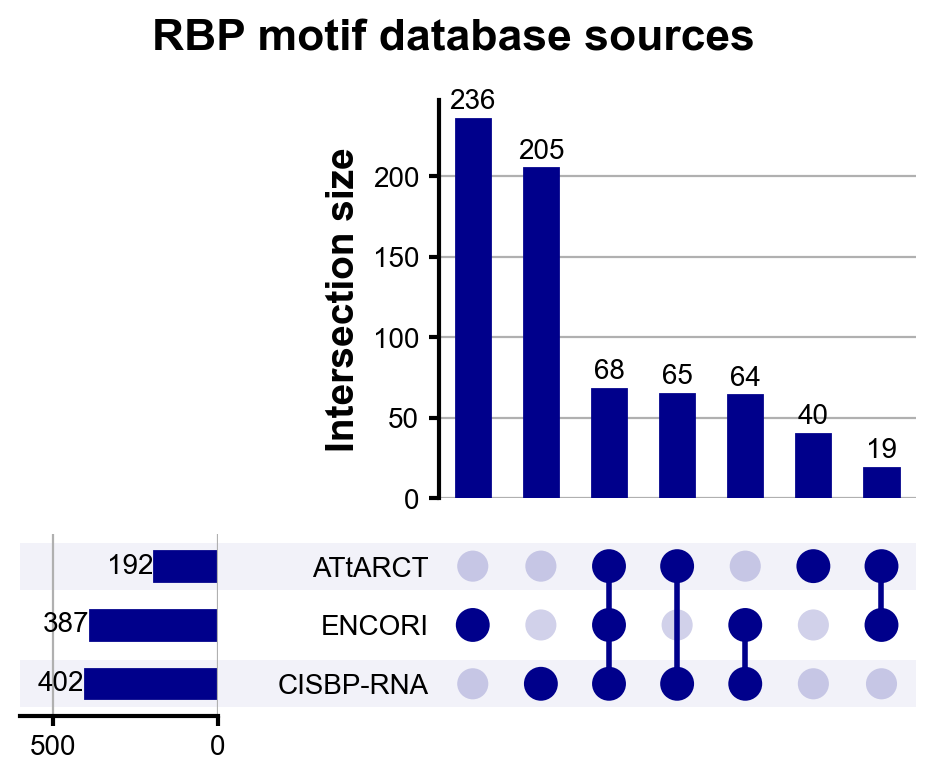

In [17]:
fig = plt.figure(figsize=(10, 6), dpi=200)
plot_axes = upset.plot(fig=fig)
ax_totals = plot_axes['totals']
ax_totals.set_xlim(600)
plt.suptitle("RBP motif database sources", fontsize=16, fontweight='bold')
plt.show()

In [18]:
print("Total unique RBPs collected:", len(rbp_sources))

Total unique RBPs collected: 697


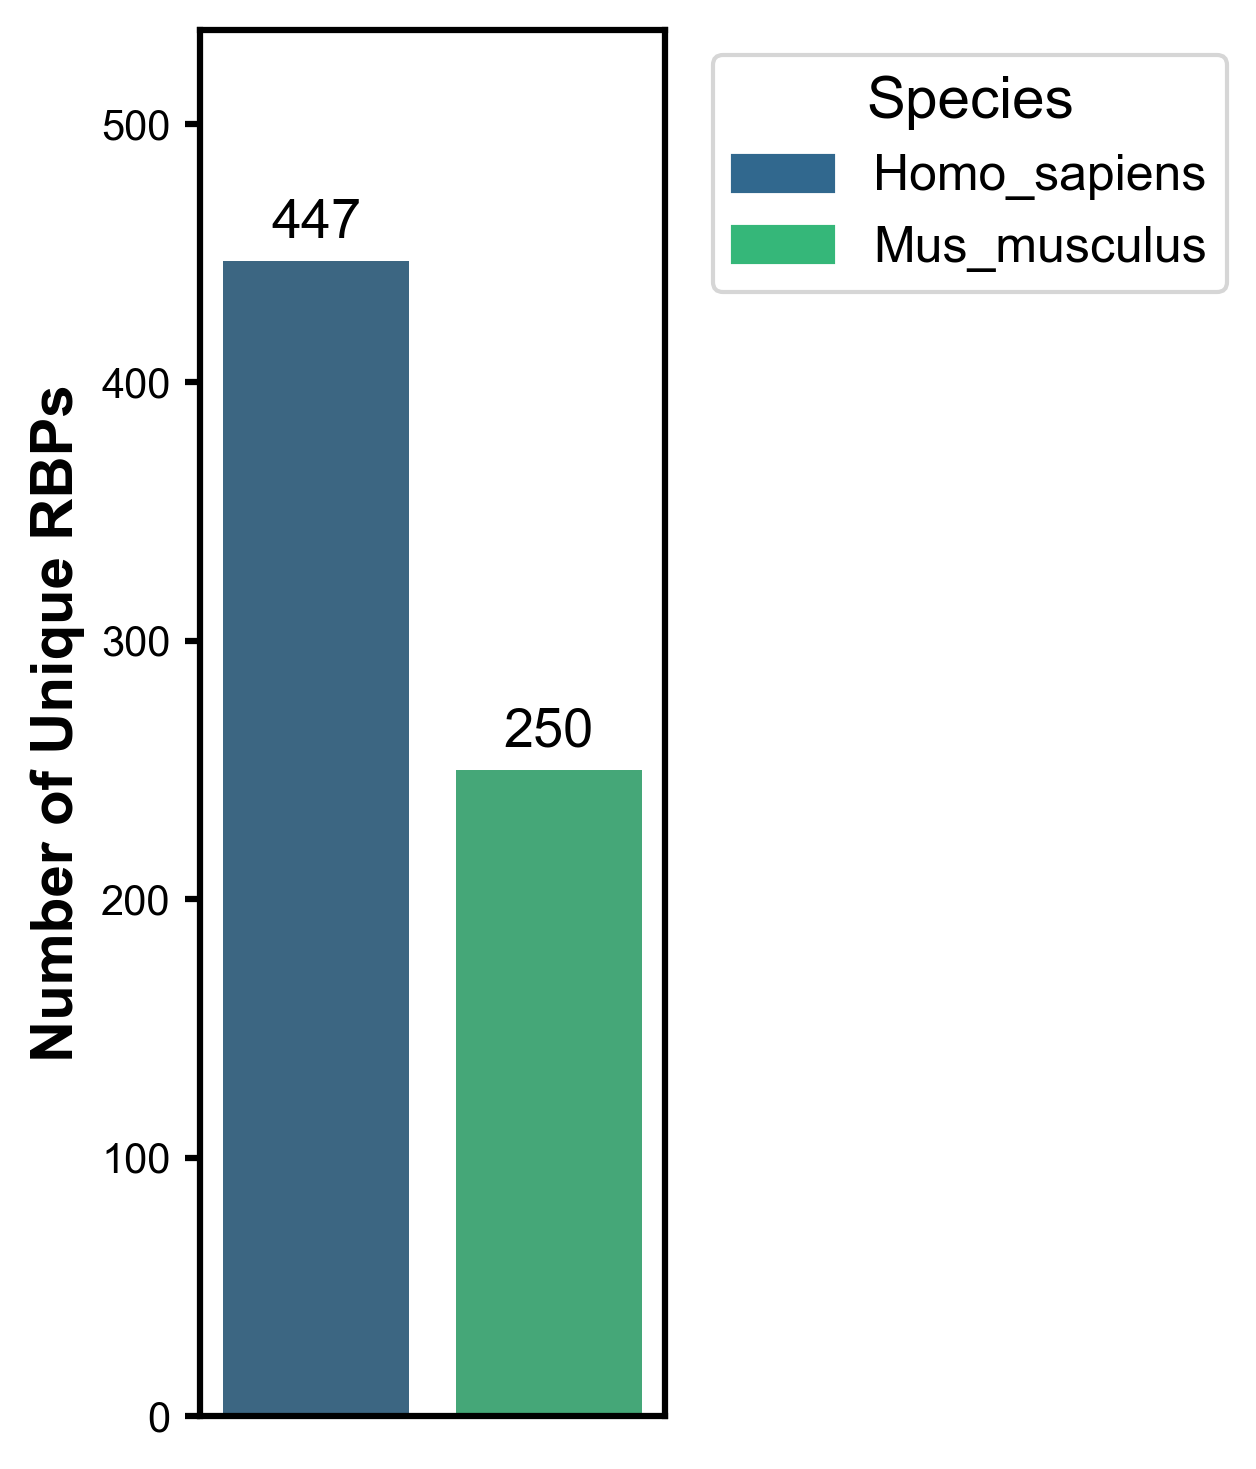

In [19]:
import seaborn as sns
import matplotlib.patches as mpatches

species_counts = defaultdict(int)
for species_set in rbp_to_species.values():
    for species in species_set:
        species_counts[species] += 1

species_df = pd.DataFrame(list(species_counts.items()), columns=['Species', 'RBP Count'])
species_df = species_df.sort_values('RBP Count', ascending=False)

plt.figure(figsize=(2, 6), dpi=300)
barplot = sns.barplot(x='Species', y='RBP Count', data=species_df, palette='viridis')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     fontsize=13,
                     textcoords = 'offset points')
    
colors = sns.color_palette('viridis', n_colors=len(species_df))
species_names = species_df['Species'].tolist()
legend_handles = [mpatches.Patch(color=colors[i], label=species_names[i]) for i in range(len(species_names))]

plt.legend(handles=legend_handles, title='Species', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

#plt.title('Distribution of RBPs by Species', fontsize=14)
plt.xlabel('')
plt.xticks([])
plt.ylabel('Number of Unique RBPs', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, species_df['RBP Count'].max() * 1.2)
plt.tight_layout()
plt.show()

In [20]:
# save rbp_to_species to csv, columns: RBP, Species
rbp_species_list = []
for rbp, species_set in rbp_to_species.items():
    for species in species_set:
        rbp_species_list.append({'RBP': rbp, 'Species': species})
rbp_species_df = pd.DataFrame(rbp_species_list)
rbp_species_df.to_csv(os.path.join(workdir, "rbp_to_species.csv"), index=False)